In [2]:
import os 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
import albumentations as A
from random import sample
from math import comb
from itertools import combinations
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from pathlib import Path
import random
from tqdm.notebook import tqdm
from IPython.display import clear_output
from sklearn.metrics import f1_score
import gc

In [4]:
RANDOM_STATE = 42

In [5]:
random.seed(RANDOM_STATE)

# Разбиение данных на train/test

In [30]:
all_files = ['data/damaged/' + x for x in os.listdir('data/damaged/')] + ['data/undamaged/' + x for x in os.listdir('data/undamaged/')]
df_labels = pd.DataFrame({'imgs': all_files})
df_labels['damaged'] = df_labels['imgs'].apply(lambda x: 1 if '/damaged/' in x else 0).astype(str)

In [36]:
X, y = df_labels['imgs'], df_labels['damaged']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=RANDOM_STATE, test_size=0.25)

In [49]:
import shutil
from tqdm import tqdm

for file in tqdm(X_train):
    if '/damaged/' in file:
        dest = 'D:/projects/ai_acts/binary_classification_damaged_terminals/dummy_classif/data/splitted_data/train/damaged'
    else:
        dest = 'D:/projects/ai_acts/binary_classification_damaged_terminals/dummy_classif/data/splitted_data/train/undamaged'
    shutil.copy2(file, dest)

for file in tqdm(X_test):
    if '/damaged/' in file:
        dest = 'D:/projects/ai_acts/binary_classification_damaged_terminals/dummy_classif/data/splitted_data/test/damaged'
    else:
        dest = 'D:/projects/ai_acts/binary_classification_damaged_terminals/dummy_classif/data/splitted_data/test/undamaged'
    shutil.copy2(file, dest)

100%|██████████| 1270/1270 [00:26<00:00, 47.07it/s]


# Обучение модели

In [6]:
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [7]:
# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "splitted_data"
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\splitted_data'.
There are 2 directories and 0 images in 'data\splitted_data\test'.
There are 0 directories and 95 images in 'data\splitted_data\test\damaged'.
There are 0 directories and 1175 images in 'data\splitted_data\test\undamaged'.
There are 2 directories and 0 images in 'data\splitted_data\train'.
There are 0 directories and 283 images in 'data\splitted_data\train\damaged'.
There are 0 directories and 3525 images in 'data\splitted_data\train\undamaged'.


In [8]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/splitted_data/train'),
 WindowsPath('data/splitted_data/test'))

Random image path: data\splitted_data\test\undamaged\ЗНО0301637031_TS903180313-13e02ff6-fcad-4d3b-be78-6b508066699f.jpg
Image class: undamaged
Image height: 2080
Image width: 1560


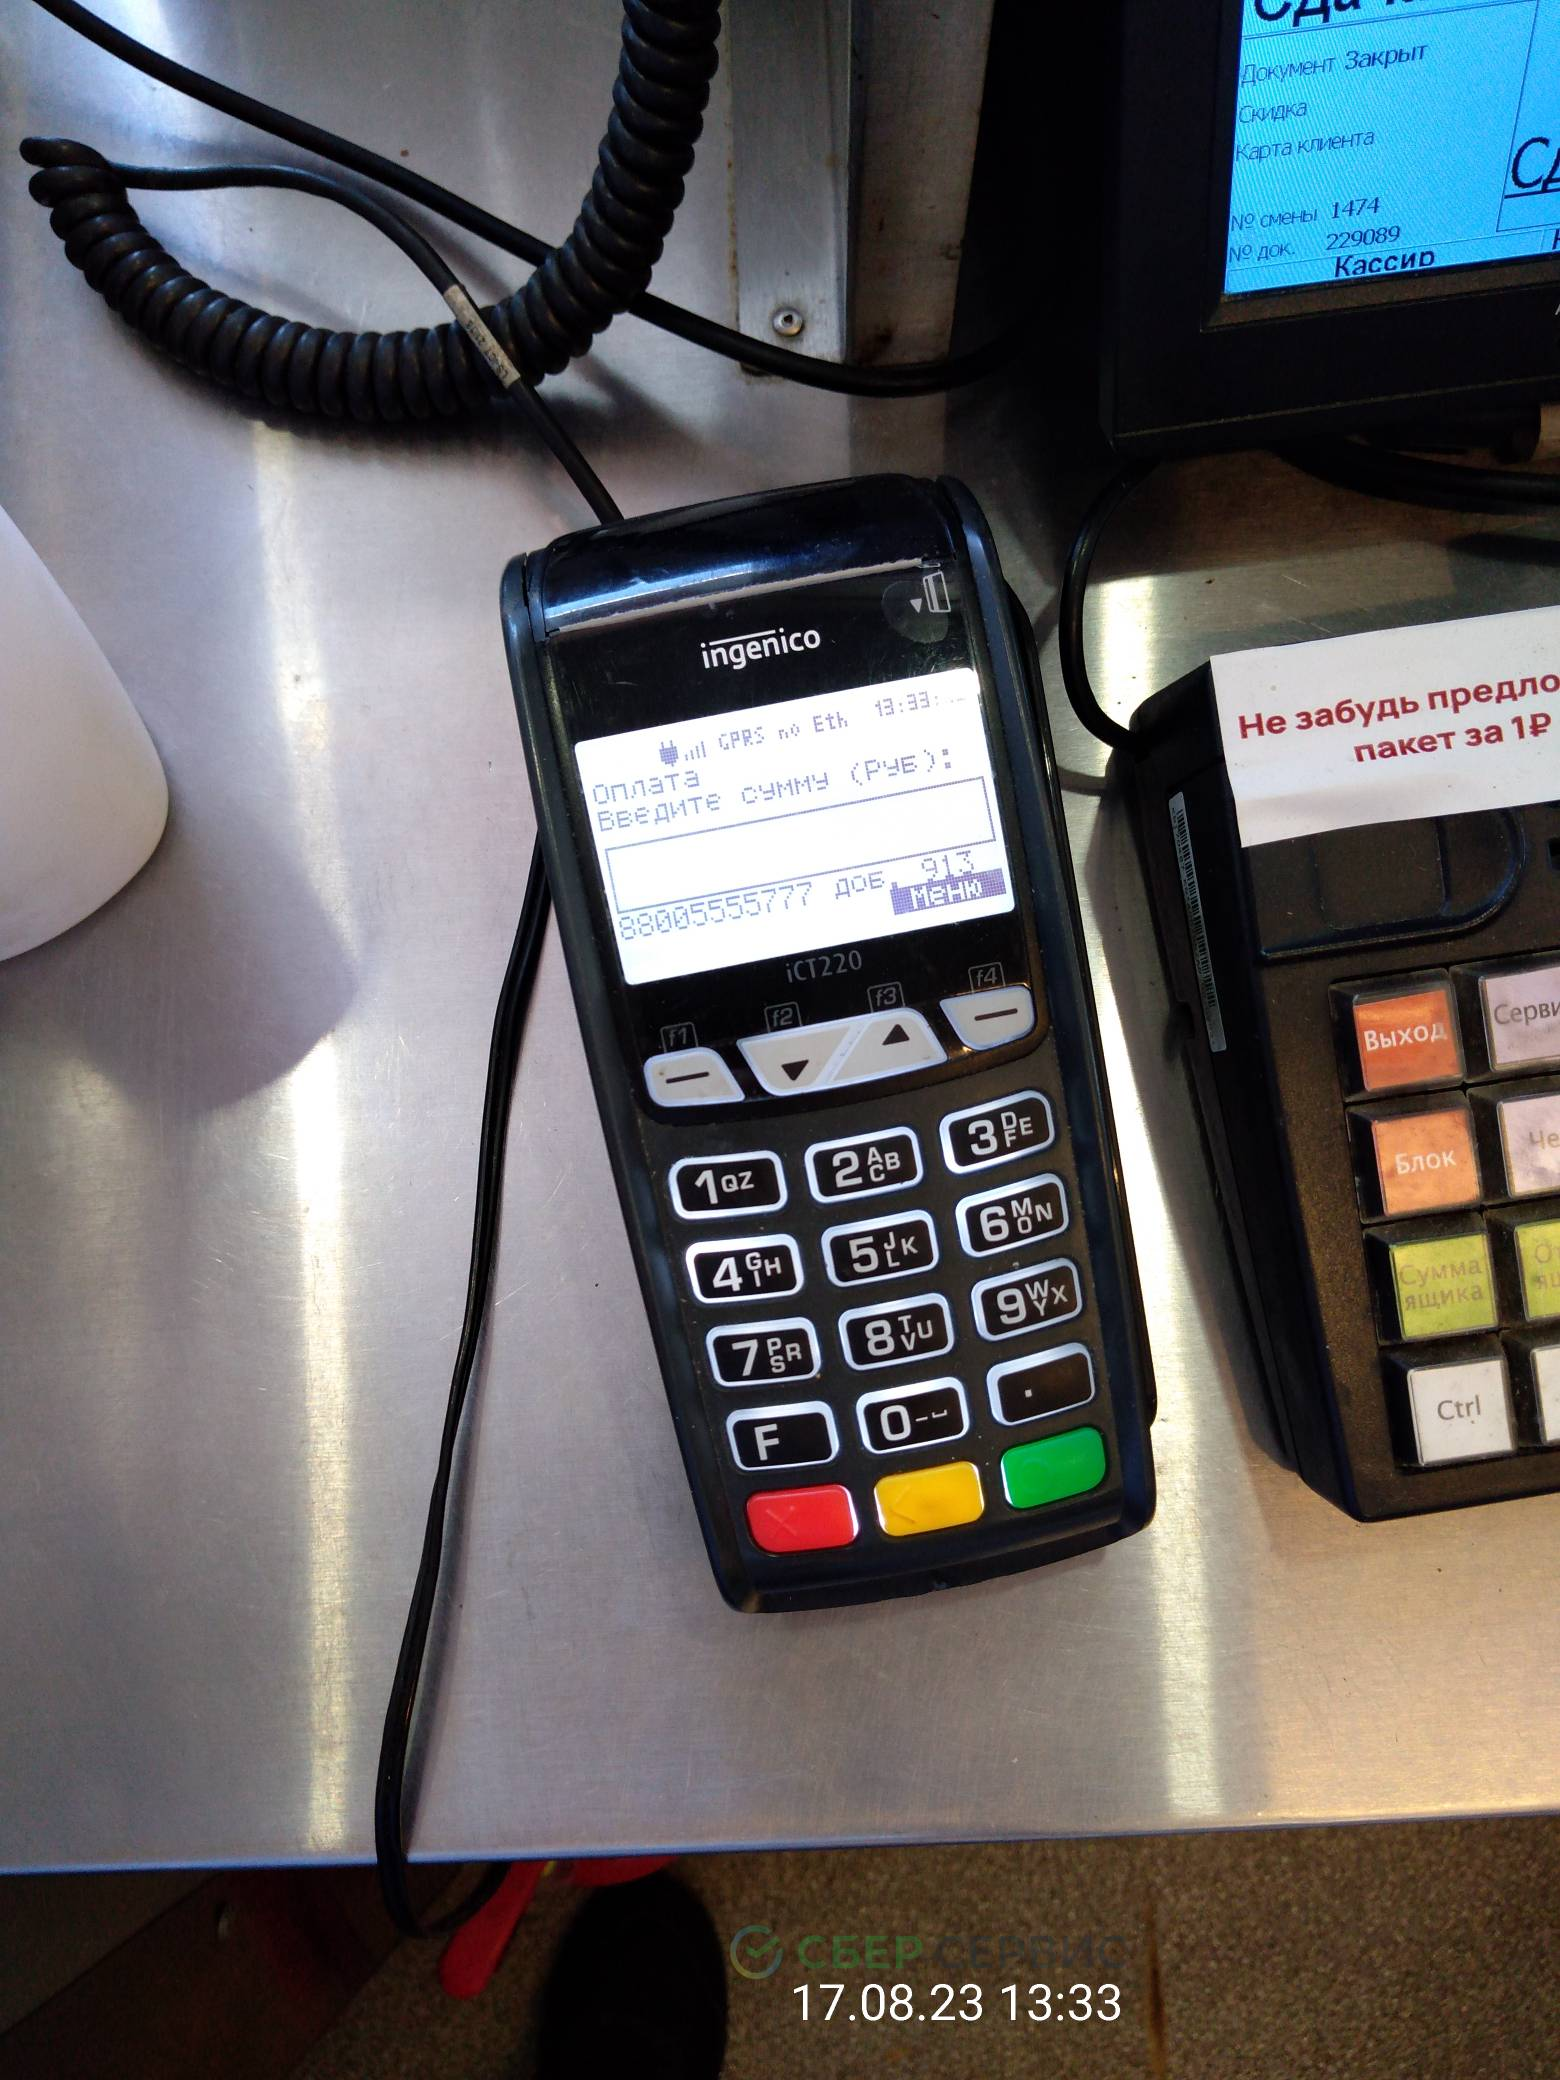

In [9]:
# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

In [11]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

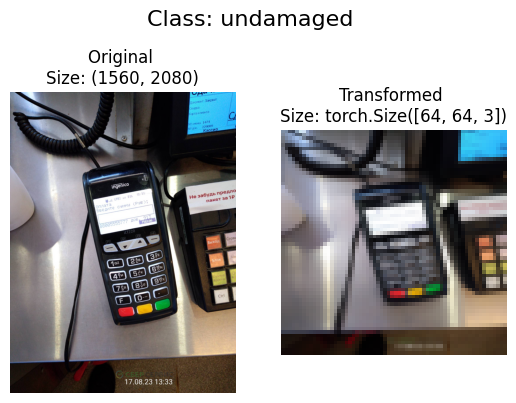

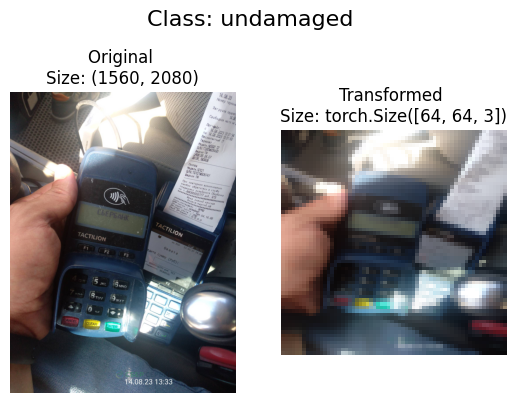

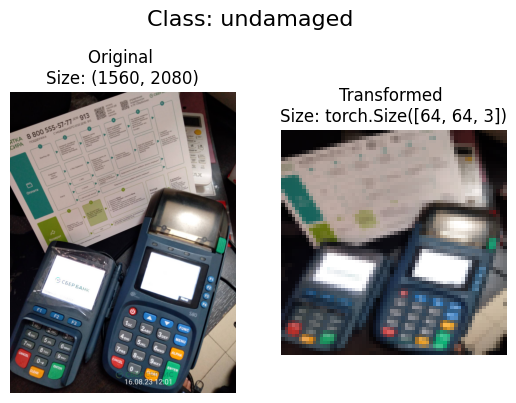

In [12]:
def plot_transformed_images(image_paths, transform, n=3, seed=RANDOM_STATE):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

In [13]:
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)
test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)
print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 3808
    Root location: data\splitted_data\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 1270
    Root location: data\splitted_data\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [14]:
# Get class names as a list
class_names = train_data.classes
class_names

['damaged', 'undamaged']

In [15]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'damaged': 0, 'undamaged': 1}

In [16]:
# Setup batch size and number of workers 
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader = DataLoader(train_data, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True, 
                                     num_workers=NUM_WORKERS)

test_dataloader = DataLoader(test_data, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

train_dataloader, test_dataloader

Creating DataLoader's with batch size 32 and 20 workers.


(<torch.utils.data.dataloader.DataLoader at 0x2afe5901d20>,
 <torch.utils.data.dataloader.DataLoader at 0x2afe5900bb0>)

# Обучаем модель из TorchVision

In [17]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

In [43]:
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies, train_f1s, test_f1s):
    clear_output()
    fig, axs = plt.subplots(1, 3, figsize=(20, 10))
    plt.rcParams['font.size'] = '12'
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(test_accuracies) + 1), test_accuracies, label='test')
    axs[1].set_ylabel('accuracy')

    axs[2].plot(range(1, len(train_f1s) + 1), train_f1s, label='train')
    axs[2].plot(range(1, len(test_f1s) + 1), test_f1s, label='test')
    axs[2].set_ylabel('F1')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [44]:
def training_epoch(model, optimizer, criterion, train_loader, tqdm_desc):
    train_loss, train_accuracy, f1_score_value = 0.0, 0.0, 0.0
    model.train()
    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size

        optimizer.zero_grad()
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]
        train_accuracy += (logits.argmax(dim=1) == labels).sum().item()

        # Calculate F1-score
        predictions = logits.argmax(dim=1)
        f1_score_value += f1_score(labels.cpu().numpy(), predictions.cpu().numpy(), average='macro')
    
    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    f1_score_value /= len(train_loader)
    
    return train_loss, train_accuracy, f1_score_value


@torch.no_grad()
def validation_epoch(model, criterion, test_loader, tqdm_desc):
    test_loss, test_accuracy, test_f1 = 0.0, 0.0, 0.0
    model.eval()
    for images, labels in tqdm(test_loader, desc=tqdm_desc):
        images = images.to(device)  # images: batch_size x num_channels x height x width
        labels = labels.to(device)  # labels: batch_size
        logits = model(images)  # logits: batch_size x num_classes
        loss = criterion(logits, labels)

        test_loss += loss.item() * images.shape[0]
        test_accuracy += (logits.argmax(dim=1) == labels).sum().item()
        # Calculate F1-score
        predictions = logits.argmax(dim=1)
        test_f1 += f1_score(labels.cpu().numpy(), predictions.cpu().numpy(), average='macro')

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    test_f1 /= len(test_loader)

    return test_loss, test_accuracy, test_f1

    
def train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs):
    train_losses, train_accuracies, train_f1s = [], [], []
    test_losses, test_accuracies, test_f1s = [], [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy, train_f1 = training_epoch(
            model, optimizer, criterion, train_loader,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        test_loss, test_accuracy, test_f1 = validation_epoch(
            model, criterion, test_loader,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )

        if scheduler is not None:
            scheduler.step()

        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        train_f1s += [train_f1]
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        test_f1s += [test_f1]
        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies, train_f1s, test_f1s)

    return train_losses, test_losses, train_accuracies, test_accuracies, train_f1s, test_f1s

In [48]:
num_epochs = 10

model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
# Заменяем исходную голову модели на голову с правильным числом классов
model.classifier[1] = torch.nn.Linear(1280, 2)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

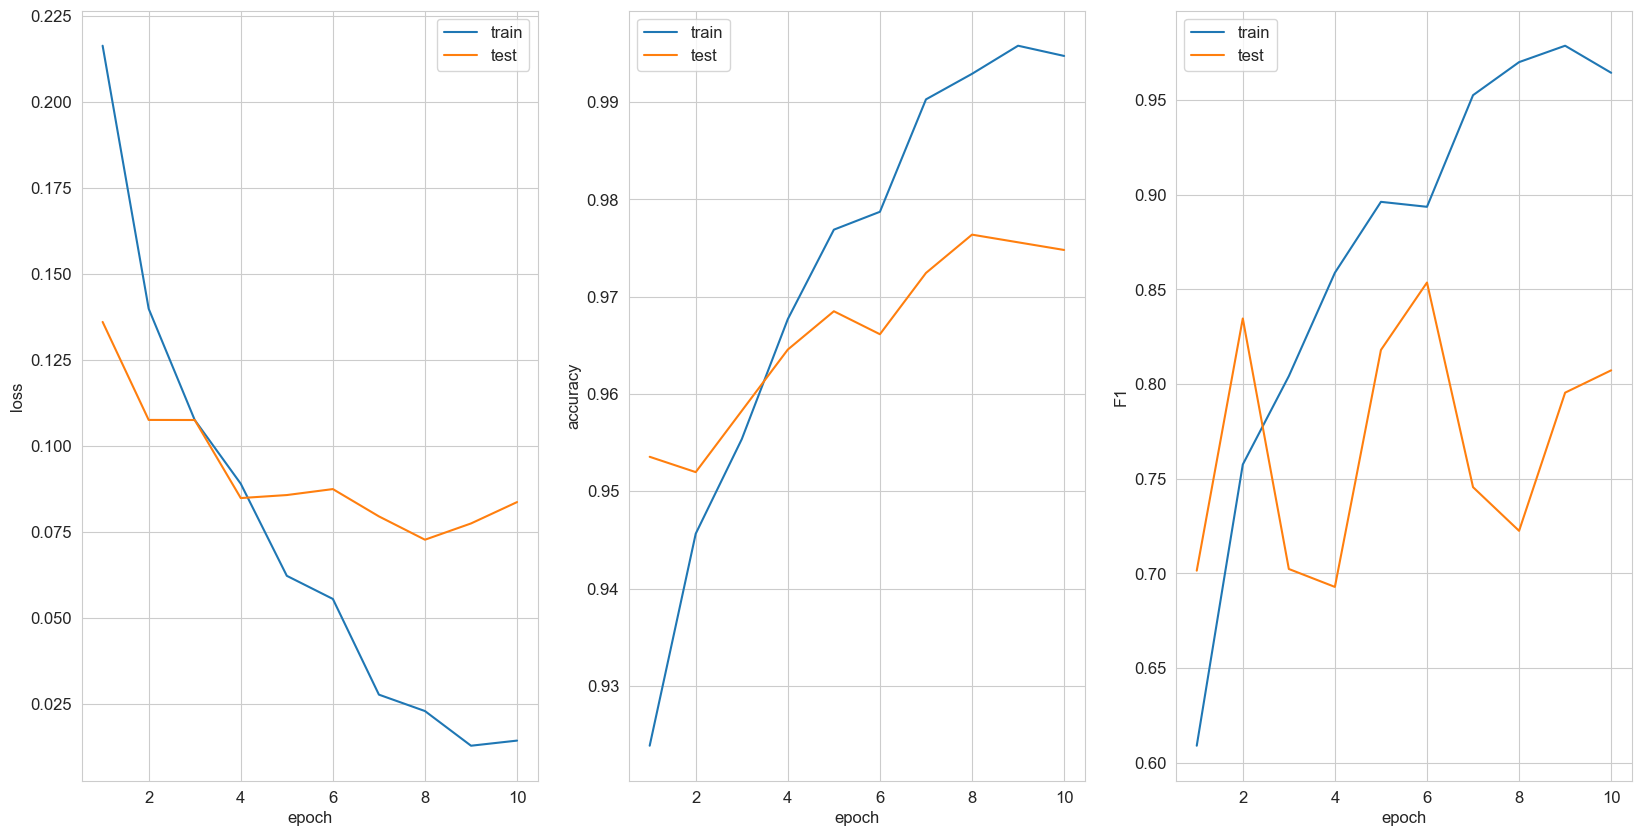

In [49]:
gc.collect()
train_losses, test_losses, train_accuracies, test_accuracies, train_f1s, test_f1s = train(
    model, optimizer, scheduler, criterion, train_dataloader, test_dataloader, num_epochs
)

In [51]:
model_scripted = torch.jit.script(model)
model_scripted.save('model_scripted.pt')

# Валидация

In [52]:
# Define the confusion matrix
num_classes = 2  # Assuming you have 2 classes (binary classification)
confusion_matrix = torch.zeros(num_classes, num_classes)

# Set the model to evaluation mode
model.eval()

# Iterate over the test dataloader batches
for inputs, labels in test_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Forward pass through the model
    outputs = model(inputs)

    # Get the predicted labels by taking the argmax of the outputs
    _, predicted_labels = torch.max(outputs, 1)

    # Update the confusion matrix
    for i in range(len(labels)):
        true_label = labels[i]
        predicted_label = predicted_labels[i]
        confusion_matrix[true_label][predicted_label] += 1

# Print the confusion matrix
print(confusion_matrix)

tensor([[  78.,   17.],
        [  15., 1160.]])


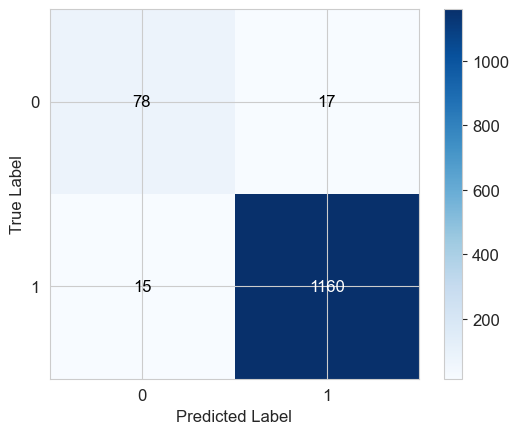

In [53]:
# Convert the confusion matrix to a numpy array
confusion_matrix = confusion_matrix.numpy()

# Plot the confusion matrix
plt.imshow(confusion_matrix, cmap='Blues')
plt.colorbar()

# Add labels and ticks to the plot
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add the values to the plot
thresh = confusion_matrix.max() / 2.
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, int(confusion_matrix[i, j]),
                 ha="center", va="center",
                 color="white" if confusion_matrix[i, j] > thresh else "black")

# Show the plot
plt.show()

# Изменение порогов

In [ ]:
model = torch.jit.load('model_scripted.pt')
model.eval()

In [ ]:
thresholds = np.linspace(0, 1, 40)
dict_threshold_metrics = {}
for threshold in tqdm(thresholds, position=0):
    # списки с метриками
    tns, fps, fns, tps = [], [], [], []
    # итерирование по датасету
    for img, lbl in tqdm(test_dataloader, position=1, leave=False):
        logits = model(img)
        p = torch.nn.functional.softmax(logits, dim=1)
        predicted_labels = (p > threshold).float().argmax(dim=1)
        tn = torch.sum((predicted_labels == 0) & (lbl == 0))
        fp = torch.sum((predicted_labels == 1) & (lbl == 0))
        fn = torch.sum((predicted_labels == 0) & (lbl == 1))
        tp = torch.sum((predicted_labels == 1) & (lbl == 1))
        tns.append(tn)
        fps.append(fp)
        fns.append(fn)
        tps.append(tp)
    dict_threshold_metrics[threshold] = np.vstack((tns, fps, fns, tps))

In [69]:
data_metrics = []
for threshold in tqdm(thresholds):
    data_batch = dict_threshold_metrics[threshold].sum(axis=1)
    data_metrics.append(data_batch)
data_metrics = np.array(data_metrics)

  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
tns, fps, fns, tps

In [141]:
df_conf_matrix = pd.DataFrame(
    data_metrics, 
    index=thresholds, 
    columns=['True Negative', 'False Positive', 'False Negative', 'True Positive']
)
# Calculate F1 score per row
df_conf_matrix['Precision'] = df_conf_matrix['True Positive'] / (df_conf_matrix['True Positive'] + df_conf_matrix['False Positive'])
df_conf_matrix['Recall'] = df_conf_matrix['True Positive'] / (df_conf_matrix['True Positive'] + df_conf_matrix['False Negative'])
df_conf_matrix['True Negative Rate'] = df_conf_matrix['True Negative'] / (df_conf_matrix['True Negative'] + df_conf_matrix['False Positive'])
df_conf_matrix['False Negative Rate'] = df_conf_matrix['False Negative'] / (df_conf_matrix['False Negative'] + df_conf_matrix['True Positive'])
df_conf_matrix['F1_Score'] = 2 * (df_conf_matrix['Precision'] * df_conf_matrix['Recall']) / (df_conf_matrix['Precision'] + df_conf_matrix['Recall'])
df_plot = df_conf_matrix.rename(
    columns={
        'True Negative': 'Есть дефект/Модель предсказала дефект (True Negative)', 
        'True Positive': 'Нет дефекта/Модель предсказала отсутствие дефекта (True Positive)',
        'False Negative': 'Нет дефекта/Модель предсказала дефект (False Negative)', 
        'False Positive': 'Есть дефект/Модель предсказала отсустсвие дефекта (False Positive)'
    }
)

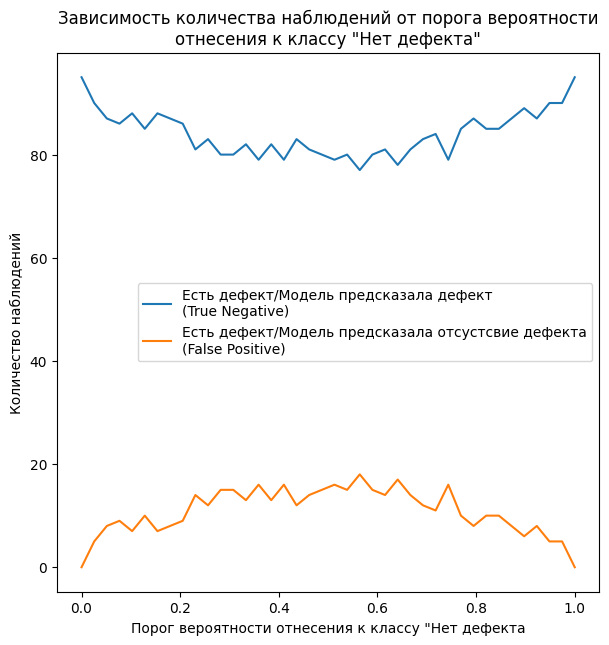

In [128]:
df_plot[[
    'Есть дефект/Модель предсказала дефект (True Negative)', 
    'Есть дефект/Модель предсказала отсустсвие дефекта (False Positive)'
    ]].plot(figsize=(7, 7))
plt.legend(['Есть дефект/Модель предсказала дефект\n(True Negative)', 
            'Есть дефект/Модель предсказала отсустсвие дефекта\n(False Positive)'])
plt.title('Зависимость количества наблюдений от порога вероятности\nотнесения к классу "Нет дефекта"')
plt.xlabel('Порог вероятности отнесения к классу "Нет дефекта')
plt.ylabel('Количество наблюдений')
plt.show()

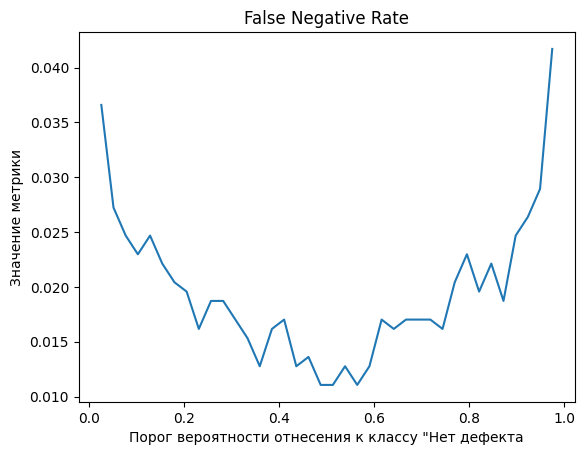

In [147]:
df_conf_matrix['False Negative Rate'].iloc[1:-1].plot()
plt.ylabel('Значение метрики')
plt.title('False Negative Rate')
plt.xlabel('Порог вероятности отнесения к классу "Нет дефекта')
plt.show()

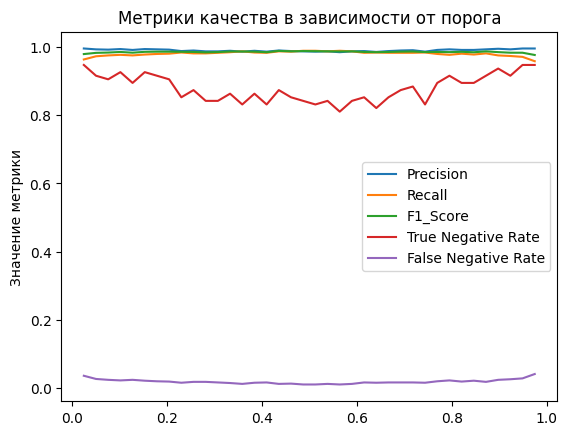

In [142]:
df_conf_matrix.iloc[1:-1][['Precision', 'Recall', 'F1_Score', 'True Negative Rate', 'False Negative Rate']].plot()
plt.ylabel('Значение метрики')
plt.title('Метрики качества в зависимости от порога')
plt.show()